In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Language model pretraining (2.1 Release Note, more detail explanation)

By far the biggest news in NLP research over 2018 was the success of language model pretraining. The basic intuition behind this has been obvious for a very long time. There's never been much doubt that NLP models need to somehow import knowledge from raw text, as labelled training corpora tend to be too small to represent long-tailed knowledge about word meanings and usage. In 2011, deep learning methods were proving successful for NLP, and techniques for pretraining word representations were already in use. A range of techniques for pretraining further layers of the network were proposed over the years, as the deep learning hype took hold. However, no one objective for the pretraining seemed to be a knockout success on a wide range of tasks.

In 2018, a number of papers showed that a simple language modelling objective worked well for LSTM models. Devlin et al. then presented a neat modification that allowed bidirectional models to be pretrained as well. One of the major themes throughout these results was that pretraining allowed extremely large models to be used, even when the labelled data is fairly small. A team from OpenAI took this one step further, training an even larger version of Devlin et al.'s model, and showing it performs well on long-form text generation.

While these large models provide convincing demonstrations, **they're not suitable for spaCy's main use-cases. The performance target we've set for ourselves is 10,000 words per second per CPU core. The v2.1 models currently run at around 8,000 words per second, so we're already slightly behind. Clearly, we couldn't use a model such as BERT or GPT-2 directly. But the same principle of pretraining should still apply, so long as we could find a way to scale it down.**

> ### The performance target we've set for ourselves is 10,000 words per second per CPU core. 


Scaling down these language models to the sizes we use in spaCy posed an interesting research challenge. Language models typically use a large output layer, with one neuron per word in the vocabulary. If you're predicting over a 10,000 word vocabulary, this means you're predicting a vector with 10,000 elements. spaCy v2.1's token vectors are 96 elements wide, so a naive softmax approach would be unlikely to work: we'd be trying to predict 100 elements of output for every 1 element of input. We could make the vocabulary somewhat smaller, but every word that's out of vocabulary is a word the pretraining process will be unable to learn. Stepping back a little, the problem of so-called "one hot" representations posing representational issues for neural networks is actually quite familiar. This is exactly what algorithms like word2vec, GloVe and FastText set out to solve. Instead of a binary vector with one dimension per entry in the vocabulary, we can have a much denser real-valued representation of the same information.

> The spacy pretrain command requires a word vectors model as part of the input, which it uses as the target output for each token. Instead of predicting a token's ID as a classification problem, we learn to predict the token's word vector. Inspired by names such as ELMo and BERT, we've termed this trick **Language Modelling with Approximate Outputs (LMAO).** Our first implementation is probably a good way to get acquainted with the idea – it's extremely short.

As is often the case in research, it seems that LMAO is an idea whose time had come. Several other researchers have been working on related ideas independently. So far we've been using L2 loss in our experiments, but Kumar and Tsvetkov (2018), who were simultaneously working on a similar idea for machine translation, have developed a novel probabilistic loss using the von Mises-Fisher distribution, which they show performs significantly better than L2 in their experiments. Even more recently, Li et al. (2019) report experiments using an LMAO objective in place of the softmax layer in the ELMo pretraining system, with promising results. In our own preliminary experiments, we've found pretraining especially effective when limited training data is available. It helps most for text categorization and parsing, but is less effective for named entity recognition. We expect the pretraining to be increasingly important as we add more abstract semantic prediction models to spaCy, for tasks such as semantic role labelling, coreference resolution and named entity linking.

#### Example: 100,000 Reddit comments
As a small example, we ran spacy pretrain for the English sm and lg models using 100,000 comments from the Reddit comments corpus:


```python
# Pretrain for the en_core_web_sm model. The sm model doesn't require the word vectors
# at runtime, while the lg model does.
python -m spacy pretrain /input/reddit-100k.jsonl en_vectors_web_lg /output

# Pretrain for the en_core_web_lg model
python -m spacy pretrain /input/reddit-100k.jsonl en_vectors_web_lg /output --use-vectors
```


We ran both pretraining jobs simultaneously on a Tesla V100, with each task training at around 50,000 tokens per second. We pretrained for 3 billion words (making several passes over the 100k comments), which took around 17 hours. The total cost of both jobs came out to about `$40.00` on Google Compute Engine. We haven't implemented resume logic yet, which will help decrease the cost of large scale jobs further, as it would allow the use of pre-emptible instances. This would take pretraining costs down to around $4 per billion words of training. 

**The spacy pretrain command saves out a weights file after each pass over the data. To use the pretrained weights, we can simply pass them as an argument to spacy train:**

```python
python -m spacy train en /models/ /corpora/PTB_SD_3_3_0/train.gold.json
/corpora/PTB_SD_3_3_0/dev.gold.json --n-examples 100 --pipeline parser
--init-tok2vec pretrain-nv-model999.bin
```

In [1]:
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.3) ======================
ℹ spaCy installation:
/Users/Ocean/.virtualenvs/general/lib/python3.7/site-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.1.0   ✔



In [2]:
import spacy
# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_sm')
# process a sentence using the model
doc = nlp("This is some text that I am processing with Spacy")
# It's that simple - all of the vectors and words are assigned after this point

In [10]:
# Get the vector for 'text':
doc[3].vector

array([ 4.568534  , -1.370492  , -0.10243708, -4.9273725 , -2.8822362 ,
       -0.43979168,  1.2032022 ,  1.539654  , -1.4354546 ,  3.725113  ,
       -2.8059876 ,  2.9812315 ,  1.817046  ,  0.39551175,  2.4117086 ,
        2.4071648 ,  4.280481  , -1.0028365 ,  3.0613012 ,  3.9989853 ,
        0.4266799 , -0.4810611 ,  2.781459  ,  1.8233557 ,  3.6449585 ,
        2.931554  ,  1.6284118 ,  1.8926572 , -1.3592925 ,  2.8787358 ,
       -0.57225597, -2.539186  , -0.20420784,  0.19943705,  1.614649  ,
        5.160138  , -4.8143315 ,  1.5709063 , -1.9602243 ,  2.5604448 ,
       -0.5673953 ,  3.565825  , -0.9036477 ,  3.2363827 , -3.5073028 ,
       -0.41927445, -5.337351  , -0.74449515, -5.031135  , -2.4003181 ,
       -2.4529147 , -0.96750605, -2.6986072 , -1.4134347 ,  0.39658427,
       -1.4486932 ,  0.32196984,  1.2560596 , -2.3243914 ,  1.5871863 ,
        0.07370102, -1.7702907 ,  3.2301302 , -2.0438488 , -1.6744761 ,
        0.02871056, -0.15093124,  4.023599  , -3.7182117 ,  5.85

In [11]:
len(doc[3].vector)

96

In [8]:
# Get the mean vector for the entire sentence (useful for sentence classification etc.)
doc.vector

array([-4.9158383e-02, -2.2899616e+00,  2.5269842e-01, -2.6431209e-01,
       -1.1894754e+00, -4.9129987e-01,  1.5165387e+00,  1.6127644e+00,
       -1.3823860e+00,  2.9913145e-01, -9.8314810e-01,  8.7381285e-01,
       -1.2274878e+00,  1.0824182e+00,  5.8566272e-01, -2.0701867e-02,
        3.3010659e-01,  1.4820244e+00,  2.0354960e+00,  1.7076943e+00,
       -1.4619898e+00, -2.7528131e-01,  2.6012371e+00,  2.5300572e+00,
       -1.3915771e+00,  1.0471743e+00,  1.1071947e+00, -6.7873907e-01,
       -9.4008607e-01,  1.8030189e+00,  1.3864447e+00, -9.6817780e-01,
       -9.8889017e-01, -1.6335909e+00,  6.5532809e-01,  1.2170750e+00,
       -6.2035829e-01,  1.8760487e-01, -2.4593856e+00,  5.7861918e-01,
        2.2893906e-01,  1.0961099e+00, -1.0336214e+00,  1.9069424e+00,
       -1.7398831e+00, -1.9183344e+00, -5.8177680e-01, -6.3919365e-01,
       -6.7629862e-01, -1.7188880e+00,  2.4197014e-01, -7.0250863e-01,
       -1.7290170e+00,  8.8305938e-01,  4.5162058e-01, -8.7952787e-01,
      

In [9]:
len(doc.vector)

96

# GENSIM loading Pretrained Word2Vec 

```python
from gensim.models import KeyedVectors
# Load vectors directly from the file 1G
model = KeyedVectors.load_word2vec_format('data/GoogleGoogleNews-vectors-negative300.bin', binary=True)
# Access vectors for specific words with a keyed lookup:
vector = model['easy']
# see the shape of the vector (300,)
vector.shape
# Processing sentences is not as simple as with Spacy:
vectors = [model[x] for x in "This is some text I am processing with Spacy".split(' ')]
```

In [27]:
doc.to_json()

{'text': 'This is some text that I am processing with Spacy',
 'ents': [],
 'sents': [{'start': 0, 'end': 49}],
 'tokens': [{'id': 0,
   'start': 0,
   'end': 4,
   'pos': 'DET',
   'tag': 'DT',
   'dep': 'nsubj',
   'head': 1},
  {'id': 1,
   'start': 5,
   'end': 7,
   'pos': 'VERB',
   'tag': 'VBZ',
   'dep': 'ROOT',
   'head': 1},
  {'id': 2,
   'start': 8,
   'end': 12,
   'pos': 'DET',
   'tag': 'DT',
   'dep': 'det',
   'head': 3},
  {'id': 3,
   'start': 13,
   'end': 17,
   'pos': 'NOUN',
   'tag': 'NN',
   'dep': 'attr',
   'head': 1},
  {'id': 4,
   'start': 18,
   'end': 22,
   'pos': 'DET',
   'tag': 'WDT',
   'dep': 'dobj',
   'head': 7},
  {'id': 5,
   'start': 23,
   'end': 24,
   'pos': 'PRON',
   'tag': 'PRP',
   'dep': 'nsubj',
   'head': 7},
  {'id': 6,
   'start': 25,
   'end': 27,
   'pos': 'VERB',
   'tag': 'VBP',
   'dep': 'aux',
   'head': 7},
  {'id': 7,
   'start': 28,
   'end': 38,
   'pos': 'VERB',
   'tag': 'VBG',
   'dep': 'relcl',
   'head': 3},
  {'id':

# Custom Extension

In [3]:
import spacy
# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_sm')
# process a sentence using the model
doc = nlp("This is some text that I am processing with Spacy")
# It's that simple - all of the vectors and words are assigned after this point

In [4]:
from spacy.tokens import Doc

In [6]:
Doc.set_extension

<function Doc.set_extension>

- Define a custom attribute which becomes available as `Doc._`.

- name (unicode): Name of the attribute to set.
- default: Optional default value of the attribute.
- getter (callable): Optional getter function.
- setter (callable): Optional setter function.
- method (callable): Optional method for method extension.
- force (bool): Force overwriting existing attribute.

# Scrapy Extraction API Beta

In [7]:
import requests

### Article

In [8]:
# Multiple queries
queries = [
    {'meta': 'query1', 'url': 'https://www.scmp.com/news/asia/south-asia/article/3007050/least-20-killed-multiple-blasts-hit-churches-and-hotels-sri',
    'pageType': 'article'},
    {'meta': 'query2', 'url': 'https://www.scmp.com/news/china/diplomacy/article/3007081/china-adds-new-satellite-its-beidou-network-aims-rival-us',
    'pageType': 'article'},
    {'meta': 'query3', 'url': 'https://www.scmp.com/week-asia/economics/article/3006964/why-hong-kong-linked-kingsford-development-cant-sell-flats',
    'pageType': 'article'},
]

response = requests.post('https://developerapi.scrapinghub.com/v1/extract', 
                        auth=('cgkd3qg4p4JakYycHbWMHaVm', ''),
                        json=queries)

In [9]:
query_resutls = {result['query']['userMeta']:result for result in response.json()}

In [23]:
for query in queries:
    query_result = query_resutls[query['meta']]
    print(query_result['article']['headline'])
    print(query_result['article']['datePublished'])
    print(query_result['article']['author'])
    print(query_result['article']['authorsList'])
    print(query_result['article']['inLanguage'])
    print(query_result['article']['breadcrumbs'])
    print(query_result['article']['description'])
    print(query_result['article']['articleBody'])
    print(query_result['article']['probability'])
    print()

Three arrested over Sri Lanka bombings that killed 207
2019-04-21T13:11:16+08:00
Agence France-Presse
['Agence France-Presse']
en
[{'name': 'News', 'link': 'https://www.scmp.com/news'}, {'name': 'Asia', 'link': 'https://www.scmp.com/news/asia'}, {'name': 'South Asia', 'link': 'https://www.scmp.com/news/asia/south-asia'}]
A string of devastating bomb blasts ripped through high-end hotels and churches holding Easter services and the casualties include dozens of foreigners.
None
0.0

China adds new satellite to its Beidou network that aims to rival GPS
2019-04-21T22:00:18+08:00
Liu Zhen
['Liu Zhen']
en
[{'name': 'News', 'link': 'https://www.scmp.com/news'}, {'name': 'China', 'link': 'https://www.scmp.com/news/china'}, {'name': 'Diplomacy', 'link': 'https://www.scmp.com/news/china/diplomacy'}]
There are now 20 satellites in orbit for the navigation system, which is expected to be completed next year.
None
0.0

Why Hong Kong-linked developer can’t sell flats on a US$600m Singapore property


In [34]:
print(response.status_code == requests.codes.ok)  # False
print(response.status_code)
print(response.headers['content-type'])
response.json()[0].keys()

True
200
application/json


dict_keys(['query', 'error', 'html', 'metadata', 'article', 'product', 'results'])

In [41]:
response.json()[0]['article']

{'articleBody': None,
 'articleBodyRaw': None,
 'headline': 'China adds new satellite to its Beidou network that aims to rival GPS',
 'inLanguage': 'en',
 'datePublished': '2019-04-21T22:00:18+08:00',
 'datePublishedRaw': '2019-04-21T22:00:18+08:00',
 'author': 'Liu Zhen',
 'authorsList': ['Liu Zhen'],
 'mainImage': 'https://cdn.i-scmp.com/sites/default/files/styles/og_image_scmp_generic/public/d8/images/methode/2019/04/21/9a2fef5e-6416-11e9-b745-17e2afcf325c_image_hires_212534.JPG?itok=WbUa23K8',
 'images': None,
 'videoUrls': None,
 'audioUrls': None,
 'description': 'There are now 20 satellites in orbit for the navigation system, which is expected to be completed next year.',
 'breadcrumbs': [{'name': 'News', 'link': 'https://www.scmp.com/news'},
  {'name': 'China', 'link': 'https://www.scmp.com/news/china'},
  {'name': 'Diplomacy', 'link': 'https://www.scmp.com/news/china/diplomacy'}],
 'url': 'https://www.scmp.com/news/china/diplomacy/article/3007081/china-adds-new-satellite-its-b

In [42]:
response1 = requests.post('https://developerapi.scrapinghub.com/v1/extract', 
                        auth=('cgkd3qg4p4JakYycHbWMHaVm', ''),
                        json=[{'url': 'https://www.bbc.co.uk/programmes/articles/5nxMx7d1K8S6nhjkPBFhHSM/withering-wit-and-words-of-wisdom-oscar-wildes-best-quotes',
                              'pageType': 'article'}])

In [43]:
response1.json()[0]['article']

{'articleBody': None,
 'articleBodyRaw': None,
 'headline': "BBC Arts - Withering wit and words of wisdom: Oscar Wilde's best quotes",
 'inLanguage': 'en',
 'datePublished': '2019-04-17T00:00:00',
 'datePublishedRaw': '17 April 2019',
 'author': 'BBC',
 'authorsList': ['BBC'],
 'mainImage': 'https://ichef.bbci.co.uk/images/ic/1040x1040/p076j0gs.jpg',
 'images': ['https://ichef.bbci.co.uk/images/ic/256xn/p076j0gs.jpg',
  'https://ichef.bbci.co.uk/images/ic/256xn/p05nlvln.jpg'],
 'videoUrls': None,
 'audioUrls': None,
 'description': 'A section of Oscar Wilde’s best put downs in his own words.',
 'breadcrumbs': None,
 'url': 'https://www.bbc.co.uk/programmes/articles/5nxMx7d1K8S6nhjkPBFhHSM/withering-wit-and-words-of-wisdom-oscar-wildes-best-quotes',
 'probability': 0.970164954662323}

# Pandas Wide-Long Pivot-table

In [44]:
np.random.seed(123)
df = pd.DataFrame({"A1970" : {0 : "a", 1 : "b", 2 : "c"},
                   "A1980" : {0 : "d", 1 : "e", 2 : "f"},
                   "B1970" : {0 : 2.5, 1 : 1.2, 2 : .7},
                   "B1980" : {0 : 3.2, 1 : 1.3, 2 : .1},
                   "X"     : dict(zip(range(3), np.random.randn(3)))
                  })

In [45]:
df # long-form

,A1970,A1980,B1970,B1980,X
0,a,d,2.5,3.2,-1.085631
1,b,e,1.2,1.3,0.997345
2,c,f,0.7,0.1,0.282978


In [46]:
df["id"] = df.index

In [47]:
df

,A1970,A1980,B1970,B1980,X,id
0,a,d,2.5,3.2,-1.085631,0
1,b,e,1.2,1.3,0.997345,1
2,c,f,0.7,0.1,0.282978,2


```shell
Wide panel to long format. Less flexible but more user-friendly than melt.

With stubnames ['A', 'B'], this function expects to find one or more
group of columns with format
A-suffix1, A-suffix2,..., B-suffix1, B-suffix2,...
You specify what you want to call this suffix in the resulting long format
with `j` (for example `j='year'`)

Each row of these wide variables are assumed to be uniquely identified by
`i` (can be a single column name or a list of column names)
```

In [48]:
pd.wide_to_long(df, ["A", "B"], i="id", j="year")

,,X,A,B
id,year,,,
0,1970,-1.085631,a,2.5
1,1970,0.997345,b,1.2
2,1970,0.282978,c,0.7
0,1980,-1.085631,d,3.2
1,1980,0.997345,e,1.3
2,1980,0.282978,f,0.1


In [49]:
df = pd.DataFrame({
    'famid': [1, 1, 1, 2, 2, 2, 3, 3, 3],
    'birth': [1, 2, 3, 1, 2, 3, 1, 2, 3],
    'ht1': [2.8, 2.9, 2.2, 2, 1.8, 1.9, 2.2, 2.3, 2.1],
    'ht2': [3.4, 3.8, 2.9, 3.2, 2.8, 2.4, 3.3, 3.4, 2.9]
})
df

,famid,birth,ht1,ht2
0,1,1,2.8,3.4
1,1,2,2.9,3.8
2,1,3,2.2,2.9
3,2,1,2.0,3.2
4,2,2,1.8,2.8
5,2,3,1.9,2.4
6,3,1,2.2,3.3
7,3,2,2.3,3.4
8,3,3,2.1,2.9


In [50]:
l = pd.wide_to_long(df, stubnames='ht', i=['famid', 'birth'], j='age')
l

ht
famid birth age     
1     1     1    2.8
            2    3.4
      2     1    2.9
            2    3.8
      3     1    2.2
            2    2.9
2     1     1    2.0
            2    3.2
      2     1    1.8
            2    2.8
      3     1    1.9
            2    2.4
3     1     1    2.2
            2    3.3
      2     1    2.3
            2    3.4
      3     1    2.1
            2    2.9

In [52]:
w = l.unstack()
w.columns = w.columns.map('{0[0]}{0[1]}'.format)
w.reset_index()
w

ht1  ht2
famid birth          
1     1      2.8  3.4
      2      2.9  3.8
      3      2.2  2.9
2     1      2.0  3.2
      2      1.8  2.8
      3      1.9  2.4
3     1      2.2  3.3
      2      2.3  3.4
      3      2.1  2.9

In [53]:
import pandas as pd

# Display 6 columns for viewing purposes
pd.set_option('display.max_columns', 6)

# Reduce decimal points to 2
pd.options.display.float_format = '{:,.2f}'.format

realwage = pd.read_csv('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/pandas_panel/realwage.csv')

In [55]:
realwage.head()

,Unnamed: 0,Time,Country,Series,Pay period,value
0,0,2006-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"17,132.44"
1,1,2007-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,100.92"
2,2,2008-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"17,747.41"
3,3,2009-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,580.14"
4,4,2010-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,755.83"


In [56]:
realwage = realwage.pivot_table(values='value',
                                index='Time',
                                columns=['Country', 'Series', 'Pay period'])
realwage.head()

Country                                   Australia         \
Series     In 2015 constant prices at 2015 USD PPPs          
Pay period                                   Annual Hourly   
Time                                                         
2006-01-01                                20,410.65  10.33   
2007-01-01                                21,087.57  10.67   
2008-01-01                                20,718.24  10.48   
2009-01-01                                20,984.77  10.62   
2010-01-01                                20,879.33  10.57   

Country                                                        ...  \
Series     In 2015 constant prices at 2015 USD exchange rates  ...   
Pay period                                             Annual  ...   
Time                                                           ...   
2006-01-01                                          23,826.64  ...   
2007-01-01                                          24,616.84  ...   
2008-01-01                                          24,185.70  ...   
2009-01-01                                          24,496.84  ...   
2010-01-01                                          24,373.76  ...   

Country                               United States  \
Series     In 2015 constant prices at 2015 USD PPPs   
Pay period                                   Hourly   
Time                                                  
2006-01-01                                     6.05   
2007-01-01                                     6.24   
2008-01-01                                     6.78   
2009-01-01                                     7.58   
2010-01-01                                     7.88   

Country                                                               
Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Time                                                                  
2006-01-01                                          12,594.40   6.05  
2007-01-01                                          12,974.40   6.24  
2008-01-01                                          14,097.56   6.78  
2009-01-01                                          15,756.42   7.58  
2010-01-01                                          16,391.31   7.88  

[5 rows x 128 columns]

In [57]:
realwage.index = pd.to_datetime(realwage.index)
type(realwage.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [58]:
type(realwage.columns)

pandas.core.indexes.multi.MultiIndex

In [59]:
realwage.columns.names

FrozenList(['Country', 'Series', 'Pay period'])

In [60]:
realwage['United States'].head()

Series     In 2015 constant prices at 2015 USD PPPs         \
Pay period                                   Annual Hourly   
Time                                                         
2006-01-01                                12,594.40   6.05   
2007-01-01                                12,974.40   6.24   
2008-01-01                                14,097.56   6.78   
2009-01-01                                15,756.42   7.58   
2010-01-01                                16,391.31   7.88   

Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Time                                                                  
2006-01-01                                          12,594.40   6.05  
2007-01-01                                          12,974.40   6.24  
2008-01-01                                          14,097.56   6.78  
2009-01-01                                          15,756.42   7.58  
2010-01-01                                          16,391.31   7.88

In [61]:
# .stack() rotates the lowest level of the column MultiIndex to the row index
realwage.stack().head()

Country                                              Australia  \
Series                In 2015 constant prices at 2015 USD PPPs   
Time       Pay period                                            
2006-01-01 Annual                                    20,410.65   
           Hourly                                        10.33   
2007-01-01 Annual                                    21,087.57   
           Hourly                                        10.67   
2008-01-01 Annual                                    20,718.24   

Country                                                                   \
Series                In 2015 constant prices at 2015 USD exchange rates   
Time       Pay period                                                      
2006-01-01 Annual                                              23,826.64   
           Hourly                                                  12.06   
2007-01-01 Annual                                              24,616.84   
           Hourly                                                  12.46   
2008-01-01 Annual                                              24,185.70   

Country                                                Belgium  ...  \
Series                In 2015 constant prices at 2015 USD PPPs  ...   
Time       Pay period                                           ...   
2006-01-01 Annual                                    21,042.28  ...   
           Hourly                                        10.09  ...   
2007-01-01 Annual                                    21,310.05  ...   
           Hourly                                        10.22  ...   
2008-01-01 Annual                                    21,416.96  ...   

Country                                                   United Kingdom  \
Series                In 2015 constant prices at 2015 USD exchange rates   
Time       Pay period                                                      
2006-01-01 Annual                                              20,376.32   
           Hourly                                                   9.81   
2007-01-01 Annual                                              20,954.13   
           Hourly                                                  10.07   
2008-01-01 Annual                                              20,902.87   

Country                                          United States  \
Series                In 2015 constant prices at 2015 USD PPPs   
Time       Pay period                                            
2006-01-01 Annual                                    12,594.40   
           Hourly                                         6.05   
2007-01-01 Annual                                    12,974.40   
           Hourly                                         6.24   
2008-01-01 Annual                                    14,097.56   

Country                                                                   
Series                In 2015 constant prices at 2015 USD exchange rates  
Time       Pay period                                                     
2006-01-01 Annual                                              12,594.40  
           Hourly                                                   6.05  
2007-01-01 Annual                                              12,974.40  
           Hourly                                                   6.24  
2008-01-01 Annual                                              14,097.56  

[5 rows x 64 columns]

In [62]:
realwage.stack(level='Country').head()

Series               In 2015 constant prices at 2015 USD PPPs         \
Pay period                                             Annual Hourly   
Time       Country                                                     
2006-01-01 Australia                                20,410.65  10.33   
           Belgium                                  21,042.28  10.09   
           Brazil                                    3,310.51   1.41   
           Canada                                   13,649.69   6.56   
           Chile                                     5,201.65   2.22   

Series               In 2015 constant prices at 2015 USD exchange rates         
Pay period                                                       Annual Hourly  
Time       Country                                                              
2006-01-01 Australia                                          23,826.64  12.06  
           Belgium                                            20,228.74   9.70  
           Brazil                                              2,032.87   0.87  
           Canada                                             14,335.12   6.89  
           Chile                                               3,333.76   1.42

In [63]:
realwage['2015'].stack(level=(1, 2)).transpose().head()

Time                                     2015-01-01         \
Series     In 2015 constant prices at 2015 USD PPPs          
Pay period                                   Annual Hourly   
Country                                                      
Australia                                 21,715.53  10.99   
Belgium                                   21,588.12  10.35   
Brazil                                     4,628.63   2.00   
Canada                                    16,536.83   7.95   
Chile                                      6,633.56   2.80   

Time                                                                  
Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Country                                                               
Australia                                           25,349.90  12.83  
Belgium                                             20,753.48   9.95  
Brazil                                               2,842.28   1.21  
Canada                                              17,367.24   8.35  
Chile                                                4,251.49   1.81

In [64]:
realwage_f = realwage.xs(('Hourly', 'In 2015 constant prices at 2015 USD exchange rates'),
                         level=('Pay period', 'Series'), axis=1)
realwage_f.head()

Country,Australia,Belgium,Brazil,...,Turkey,United Kingdom,United States
Time,,,,,,,
2006-01-01,12.06,9.70,0.87,...,2.27,9.81,6.05
2007-01-01,12.46,9.82,0.92,...,2.26,10.07,6.24
2008-01-01,12.24,9.87,0.96,...,2.22,10.04,6.78
2009-01-01,12.40,10.21,1.03,...,2.28,10.15,7.58
2010-01-01,12.34,10.05,1.08,...,2.30,9.96,7.88


# Mixed Effect Linear Model

In [76]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("Weight ~ Time + Feed", data, groups=data["Pig"], missing='drop')
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 789     Method:             REML      
No. Groups:       72      Scale:              7.3643    
Min. group size:  10      Likelihood:         -2050.9717
Max. group size:  11      Converged:          Yes       
Mean group size:  11.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     19.948    0.796 25.048 0.000 18.387 21.509
Time           4.303    0.186 23.103 0.000  3.938  4.669
Feed           0.172    0.011 15.259 0.000  0.150  0.195
Group Var     31.836    2.125                           



```python
- compute.[use_bottleneck, use_numexpr]
- display.[chop_threshold, colheader_justify, column_space, date_dayfirst,
  date_yearfirst, encoding, expand_frame_repr, float_format]
- display.html.[border, table_schema, use_mathjax]
- display.[large_repr]
- display.latex.[escape, longtable, multicolumn, multicolumn_format, multirow,
  repr]
- display.[max_categories, max_columns, max_colwidth, max_info_columns,
  max_info_rows, max_rows, max_seq_items, memory_usage, multi_sparse,
  notebook_repr_html, pprint_nest_depth, precision, show_dimensions]
- display.unicode.[ambiguous_as_wide, east_asian_width]
- display.[width]
- html.[border]
- io.excel.xls.[writer]
- io.excel.xlsm.[writer]
- io.excel.xlsx.[writer]
- io.hdf.[default_format, dropna_table]
- io.parquet.[engine]
- mode.[chained_assignment, sim_interactive, use_inf_as_na, use_inf_as_null]
- plotting.matplotlib.[register_converters]
```

In [85]:
pd.set_option('display.max_columns', 20)
data.dropna(inplace=True)
data.head()

,Weight,Feed,Time,Pig,Evit,Cu,Litter
0,26.50,nan,1,4601,1,1,1
1,27.60,5.20,2,4601,1,1,1
2,36.50,17.60,3,4601,1,1,1
3,40.30,28.50,4,4601,1,1,1
4,49.10,45.20,5,4601,1,1,1


# Multi-Task ElasticNet

In [77]:
from sklearn import linear_model

In [94]:
clf = linear_model.MultiTaskElasticNetCV(cv=5, n_jobs=-1)

In [100]:
clf.fit(data[['Feed']], data[['Weight', 'Feed']])

MultiTaskElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001,
           fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
           n_jobs=-1, normalize=False, random_state=None,
           selection='cyclic', tol=0.0001, verbose=0)

In [101]:
clf.coef_

array([[0.43112407],
       [0.99791294]])

In [133]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Multi-Task Lasso

- Fit multiple regression jointly enforcing identical features across tasks
- Example each task a time instant
- Imposing features selected (lasso) at one instant selected for all time
- Making feature selection by Lasso more stable

In [102]:
import matplotlib.pyplot as plt
from sklearn.linear_model import MultiTaskLasso, Lasso

In [103]:
rng = np.random.RandomState(42)

In [182]:
n_samples, n_features, n_tasks = 100, 30, 40
n_relevant_features = 10
coef = np.zeros((n_tasks, n_features))
times = np.linspace(0, 2 * np.pi, n_tasks)
for k in range(n_relevant_features):
    coef[:, k] = np.sin((1. + rng.randn(1)) * times + 3 * rng.randn(1))

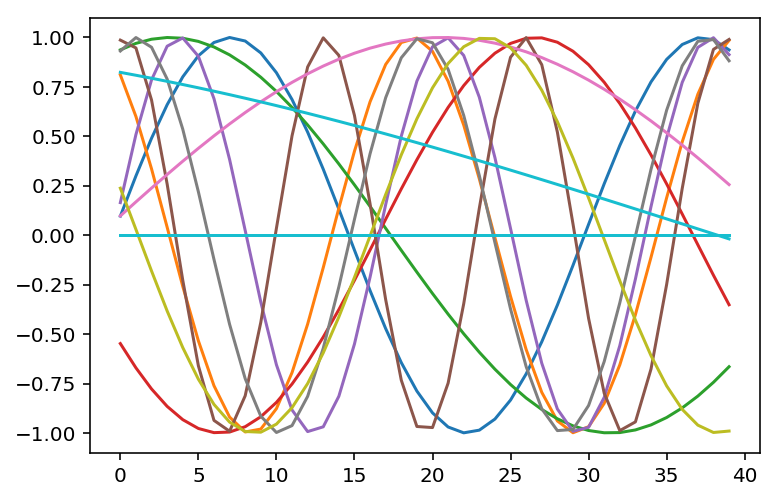

In [183]:
plt.plot(coef);

In [184]:
X = rng.randn(n_samples, n_features)
Y = np.dot(X, coef.T) + rng.randn(n_samples, n_tasks)

In [185]:
coef_lasso_ = np.array([Lasso(alpha=0.5).fit(X, y).coef_ for y in Y.T])

In [186]:
coef_multi_task_lasso_ = MultiTaskLasso(alpha=1.).fit(X, Y).coef_

In [206]:
coef_multi_task_lasso_cv_ = linear_model.MultiTaskLassoCV(cv=5).fit(X, Y).coef_

In [200]:
# MultiTask ElasticNet
clf.fit(X, Y)

MultiTaskElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001,
           fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
           n_jobs=-1, normalize=False, random_state=None,
           selection='cyclic', tol=0.0001, verbose=0)

In [201]:
clf.coef_.shape

(40, 30)

Text(0.5, 0.98, 'Coefficient non-zero location')

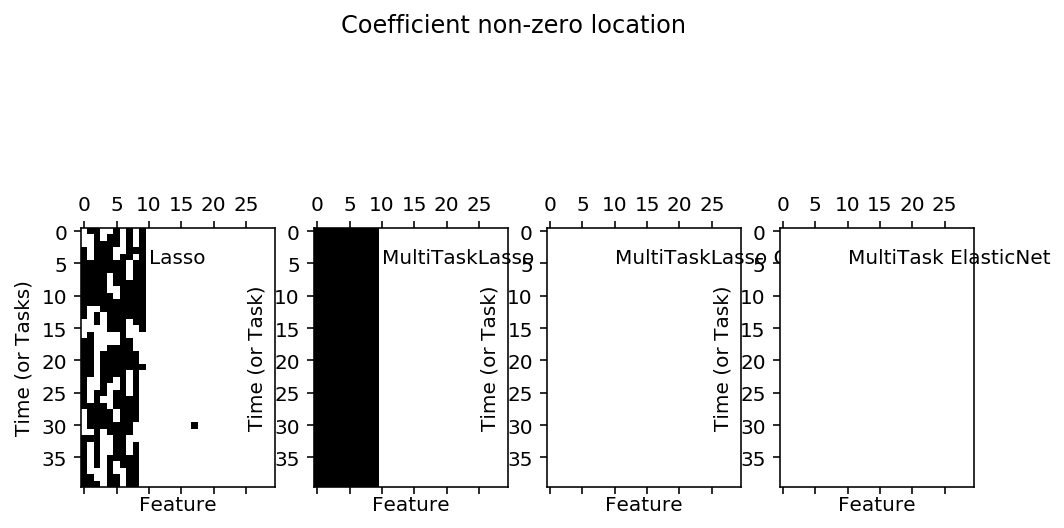

In [209]:
fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 4, 1)
plt.spy(coef_lasso_)
plt.xlabel('Feature')
plt.ylabel('Time (or Tasks)')
plt.text(10, 5, 'Lasso')
plt.subplot(1, 4, 2)
plt.spy(coef_multi_task_lasso_)
plt.xlabel('Feature')
plt.ylabel('Time (or Task)')
plt.text(10, 5, 'MultiTaskLasso')
fig.suptitle('Coefficient non-zero location')
plt.subplot(1, 4, 3)
plt.spy(coef_multi_task_lasso_cv_)
plt.xlabel('Feature')
plt.ylabel('Time (or Task)')
plt.text(10, 5, 'MultiTaskLasso CV')
fig.suptitle('Coefficient non-zero location')
plt.subplot(1, 4, 4)
plt.spy(clf.coef_.)
plt.xlabel('Feature')
plt.ylabel('Time (or Task)')
plt.text(10, 5, 'MultiTask ElasticNet')
fig.suptitle('Coefficient non-zero location')

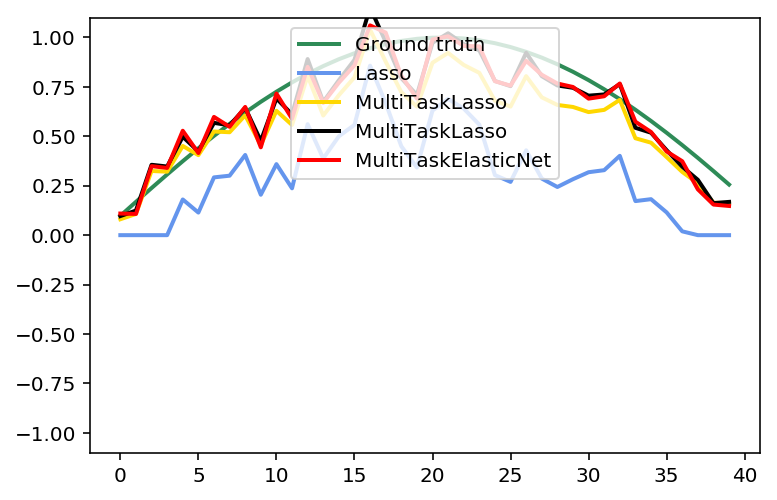

In [212]:
feature_to_plot = 6
plt.figure()
lw = 2
plt.plot(coef[:, feature_to_plot], color='seagreen', linewidth=lw,
         label='Ground truth')
plt.plot(coef_lasso_[:, feature_to_plot], color='cornflowerblue', linewidth=lw,
         label='Lasso')
plt.plot(coef_multi_task_lasso_[:, feature_to_plot], color='gold', linewidth=lw,
         label='MultiTaskLasso')
plt.plot(coef_multi_task_lasso_cv_[:, feature_to_plot], color='black', linewidth=lw,
         label='MultiTaskLasso')
plt.plot(clf.coef_[:, feature_to_plot], color='red', linewidth=lw,
         label='MultiTaskElasticNet')
plt.legend(loc='upper center')
plt.axis('tight')
plt.ylim([-1.1, 1.1])
plt.show()

# Convert HTML notebook to IPYNB

In [214]:
from bs4 import BeautifulSoup
import json
# import urllib.request
# url = 'http://nbviewer.jupyter.org/url/jakevdp.github.com/downloads/notebooks/XKCD_plots.ipynb'
# response = urllib.request.urlopen(url)
# for local html file
response = open("/Users/Ocean/Desktop/Supervised_Project_HEC.html")
text = response.read()

In [215]:
soup = BeautifulSoup(text, 'lxml')

In [219]:
dictionary = {'nbformat': 4, 'nbformat_minor': 1, 'cells': [], 'metadata': {}}
for d in soup.findAll("div"):
    if 'class' in d.attrs.keys():
        for clas in d.attrs["class"]:
            if clas in ["text_cell_render", "input_area"]:
                # code cell
                if clas == "input_area":
                    cell = {}
                    cell['metadata'] = {}
                    cell['outputs'] = []
                    cell['source'] = [d.get_text()]
                    cell['execution_count'] = None
                    cell['cell_type'] = 'code'
                    dictionary['cells'].append(cell)

                else:
                    cell = {}
                    cell['metadata'] = {}

                    cell['source'] = [d.decode_contents()]
                    cell['cell_type'] = 'markdown'
                    dictionary['cells'].append(cell)
open('Supervised_HEC.ipynb', 'w').write(json.dumps(dictionary))

26586

# BERT vs Row_Max_Similarity

In [22]:
doc1 = 'The Donald Trump baby blimp, which became the focal point\
        of protests against the US president’s visit to the UK in July,\
           will rise again for the state visit and\
           could be accompanied by a bigger version, activists have revealed.'

doc2 = 'Blimp, the latest balloon Trump will see a bigger version that could accompany the state visit.'

doc3 = 'Wednesday marked the 150th anniversay of the WWI with many celebrations around the globe. The U.S. president\
    Donal Trump issued contentious statement on the occasion remarking that the world would face the third one.'

In [23]:
# Special_SIM
import numpy as np

def cosine_similarity(vec1, vec2):
    return vec1.dot(vec2)

def row_max_similarity(doc1, doc2, sim_metric=None):
    if sim_metric is None:
        sim_metric = cosine_similarity

    doc1 = [t for t in doc1 if t.has_vector]
    doc2 = [t for t in doc2 if t.has_vector]
    N1 = len(doc1)
    N2 = len(doc2)
    similarities = np.zeros((N1, N2))
    for i in range(N1):
        vec1 = doc1[i].vector / doc1[i].vector_norm
        for j in range(N2):
            vec2 = doc2[j].vector / doc2[j].vector_norm
            similarities[i, j] = sim_metric(vec1, vec2)
    flows1 = similarities.argmax(axis=0)
    flows2 = similarities.argmax(axis=1)
    sim = (similarities.max(axis=0).sum() + similarities.max(axis=1).sum()) / (N1+N2)
    return sim, flows1, flows2

In [24]:
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.3) ======================
ℹ spaCy installation:
/Users/Ocean/.virtualenvs/general/lib/python3.7/site-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.1.0   ✔
package   en-core-web-lg   en_core_web_lg   2.1.0   ✔



In [25]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [26]:
doc1 = nlp(doc1)
doc2 = nlp(doc2)
doc3 = nlp(doc3)

In [34]:
row_max_similarity(doc1, doc2)[0]
print()
row_max_similarity(doc1, doc3)[0]
print()
row_max_similarity(doc2, doc3)[0]

0.7765253444039633

0.6460121090029493

0.6203916438475803

In [35]:
doc1.similarity(doc2)
print()
doc1.similarity(doc3)
doc2.similarity(doc3)

0.9427334649306618

0.9191492552576657

0.8654894195845644

# LexRank

In [37]:
from lexrank import STOPWORDS, LexRank

In [39]:
from path import Path

documents = []
#documents_dir = Path('/Users/Ocean/Desktop/')

#for file_path in documents_dir.files('*.txt'):
with open('/users/Ocean/Desktop/news.txt',mode='rt', encoding='utf-8') as fp:
    documents.append(fp.readlines())


In [46]:
lxr = LexRank(documents, stopwords=STOPWORDS['en'])

In [48]:
# get summary with classical LexRank algorithm
summary = lxr.get_summary(documents[0], summary_size=2, threshold=.1)
print(summary)

['“I do not think the delay [of the Galaxy Fold launch] will negatively impact the company,” said Li. “There is no mass production, so Samsung has no financial or market share loss.”', 'A Reuters report said the delay appeared to be related to the Galaxy Fold’s screen either cracking or flickering, according to Twitter posts by technology journalists from Bloomberg, The Verge and CNBC, who received the smartphone this week for review purposes.\n']


In [49]:
# get summary with continuous LexRank
summary_cont = lxr.get_summary(documents[0], threshold=None)
print(summary_cont)

['“I do not think the delay [of the Galaxy Fold launch] will negatively impact the company,” said Li. “There is no mass production, so Samsung has no financial or market share loss.”']


In [50]:
# get LexRank scores for sentences
# 'fast_power_method' speeds up the calculation, but requires more RAM
scores_cont = lxr.rank_sentences(
    documents[0],
    threshold=None,
    fast_power_method=False,
)
print(scores_cont)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
